In [222]:
from datetime import datetime, timedelta

def get_fecha(date):
    return date.strftime("%Y-%m-%d")

def str2date(string):
    return datetime.strptime(string, '%Y-%m-%d %H:%M:%S')

In [80]:
import pandas as pd

df = pd.read_csv('../data/Modelar_UH2022.txt',sep = '|') 
df = df.fillna(0)
df['DELTA'] = [j+(i/100) for (j,i) in zip(df['DELTAINTEGER'].values, df['DELTATHOUSANDTH'].values)]
df['READING'] = [j+(i/100) for (j,i) in zip(df['READINGINTEGER'].values, df['READINGTHOUSANDTH'].values)]
df = df.sort_values(['ID','SAMPLETIME']).reset_index(drop=True)
df.drop(['READINGINTEGER','READINGTHOUSANDTH','DELTAINTEGER','DELTATHOUSANDTH'], axis=1, inplace=True)

In [81]:
from tqdm import tqdm

tqdm.pandas()
df['SAMPLETIME'] = df['SAMPLETIME'].progress_apply(str2date)
df['DATE'] = df['SAMPLETIME'].progress_apply(get_fecha)
df.head()

100%|██████████████████████████████████████████████████████████████████| 21404828/21404828 [02:21<00:00, 151205.28it/s]


ID          SAMPLETIME  DELTA   READING        DATE
0   0 2019-02-01 00:39:36    0.0  331710.0  2019-02-01
1   0 2019-02-01 01:39:36    0.0  331710.0  2019-02-01
2   0 2019-02-01 02:39:35    0.0  331710.0  2019-02-01
3   0 2019-02-01 03:39:35    0.0  331710.0  2019-02-01
4   0 2019-02-01 04:39:35    0.0  331710.0  2019-02-01

In [87]:
df = df.groupby(['ID','DATE']).agg({'DELTA':sum,'READING':max}).reset_index()
df.head()

ID        DATE  DELTA   READING
0   0  2019-02-01  243.0  331953.0
1   0  2019-02-02  236.0  332189.0
2   0  2019-02-03  335.0  332524.0
3   0  2019-02-04  252.0  332776.0
4   0  2019-02-05  220.0  332996.0

In [371]:
import datetime
from tqdm import tqdm

'''
given a start date in datetime format "start_date" and an "end_date" returns a list of strings with the dates from
"start_date" to "end_date".

Example:

start_date = datetime.date(2019, 9 , 30)
end_date = datetime.date(2019, 10, 7)
get_date_range(start_date, end_date)
'''
def get_date_range(start_date, end_date):
    number_of_days = (end_date-start_date).days
    return [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days+1)]

'''
given a df in which there is one or zero entries per ID and DATE, a start_date and an end date, returns a dictionary whose
keys are ID and the days between start_date and end_date and whose values are a list of IDs for 'ID' key and a list of
the DELTA values for each ID and DATE for the keys corresponding to the days between start_date and end_date. If for some 
ID and DATE there is no such DELTA, then we take DELTA=0. The execution takes so long due to the df filtering. 

Example:

start_date = datetime.date(2019, 9 , 30)
end_date = datetime.date(2019, 10, 7)
get_set_by_days(df, start_date, end_date)
'''
def get_set_by_days(df, start_date, end_date):
    list_of_days = get_date_range(start_date, end_date)
    test_dict = {'ID':[]}
    for i in tqdm(df['ID'].unique()):
        test_dict['ID'].append(i)
        for day in list_of_days:
            filtered_df = df[(df['ID']==i) & (df['DATE']==day)]
            #comprobar que no haya mas de una entrada por ID y DATE
            if len(filtered_df)>1:
                raise Exception("More than one delta value per ID and DATE")
            #si hay una entrada, añadimos el valor de delta
            elif len(filtered_df)==1:
                delta = filtered_df.iloc[0]['READING']
                if day not in list(test_dict.keys()):
                    test_dict[day] = [delta]
                else:
                    test_dict[day].append(delta)
            #si no hay entrada añadimos None 
            else:
                if day not in test_dict.keys():
                    test_dict[day] = [None]
                else:
                    test_dict[day].append(None)
    return test_dict

In [89]:
start_date = datetime.date(2019, 2 , 1)
end_date = datetime.date(2020, 1, 31)
training_dict = get_set_by_days(df, start_date, end_date)

100%|███████████████████████████████████████████████████████████████████████████| 2747/2747 [14:28:46<00:00, 18.98s/it]


In [308]:
df = pd.DataFrame.from_dict(training_dict)

In [309]:
df.index = df['ID']
df.drop('ID',axis=1,inplace=True)
df.head()

2019-02-01  2019-02-02  2019-02-03  2019-02-04  2019-02-05  2019-02-06  \
ID                                                                           
0     331953.0   332189.00    332524.0    332776.0    332996.0   333272.00   
1       5833.0     5880.00      5886.0      5898.0      5942.0     5942.00   
2       7951.0     7951.00      7951.0      7951.0      7951.0     7951.00   
3     150771.0   151152.00    151465.0    151827.0    152207.0   152660.00   
4     113618.0   113853.67    114108.0    114520.0    114789.0   115013.54   

    2019-02-07  2019-02-08  2019-02-09  2019-02-10  ...  2020-01-22  \
ID                                                  ...               
0    333549.00    333742.0    334004.0    334319.0  ...    432045.0   
1      5949.00      5949.0      6041.0      6103.0  ...     10029.0   
2      7951.00      7951.0      7951.0      7951.0  ...     12999.0   
3    153050.00    153469.0    153928.0    154370.0  ...    308651.0   
4    115231.77    115661.0    115967.0    116162.0  ...    207482.0   

    2020-01-23  2020-01-24  2020-01-25  2020-01-26  2020-01-27  2020-01-28  \
ID                                                                           
0     432376.0   432744.00    433134.0    433438.0   433651.00    433883.0   
1      10032.0    10037.67     10039.0     10042.0    10046.00     10047.0   
2      13019.0    13056.00     13086.0     13118.0    13157.00     13197.0   
3     308972.0   309411.00    310050.0    310400.0   310689.00    311069.0   
4     207843.0   208046.00    208318.0    208600.0   208863.06    209167.0   

    2020-01-29  2020-01-30  2020-01-31  
ID                                      
0     434286.0    434711.0    434966.0  
1      10049.0     10059.0     10092.0  
2      13242.0     13269.0     13328.0  
3     311473.0    311812.0    312203.0  
4     209588.0    210008.0    210262.0  

[5 rows x 365 columns]

In [310]:
with_missings = (df.T).isna().sum()[(df.T).isna().sum() > 0]
with_missings

ID
11       85
23       20
26       96
32       64
33       18
       ... 
2746    362
2747    364
2748    361
2749    363
2756    364
Length: 772, dtype: int64

In [311]:
t_dict = (df.T).to_dict('list')

In [312]:
import numpy as np

def complete_huecos(readings):
    num_none_seguidos = 0
    last_reading = readings[0]
    for (i,current_reading) in enumerate(readings):
        if np.isnan(current_reading):
            if np.isnan(last_reading):
                continue
            else:
                num_none_seguidos += 1
        elif not np.isnan(current_reading) and num_none_seguidos>0:
            num_none_seguidos +=1
            step = (current_reading-last_reading)/num_none_seguidos
            array_para_rellenar = [last_reading + step*i for i in range(num_none_seguidos)]
            for j in range(num_none_seguidos):
                 readings[i-num_none_seguidos+j] = array_para_rellenar[j]
            num_none_seguidos = 0
        elif not np.isnan(current_reading) and num_none_seguidos==0:
            last_reading = current_reading
    return readings
            

In [313]:
for i in tqdm(t_dict):
    t_dict[i] = complete_huecos(t_dict[i])

100%|████████████████████████████████████████████████████████████████████████████| 2747/2747 [00:02<00:00, 1031.76it/s]


In [314]:
df2 = pd.DataFrame.from_dict(t_dict)
df2 = df2.T
df2.head()

0          1         2         3         4          5          6    \
0  331953.0  332189.00  332524.0  332776.0  332996.0  333272.00  333549.00   
1    5833.0    5880.00    5886.0    5898.0    5942.0    5942.00    5949.00   
2    7951.0    7951.00    7951.0    7951.0    7951.0    7951.00    7951.00   
3  150771.0  151152.00  151465.0  151827.0  152207.0  152660.00  153050.00   
4  113618.0  113853.67  114108.0  114520.0  114789.0  115013.54  115231.77   

        7         8         9    ...       355       356        357       358  \
0  333742.0  334004.0  334319.0  ...  432045.0  432376.0  432744.00  433134.0   
1    5949.0    6041.0    6103.0  ...   10029.0   10032.0   10037.67   10039.0   
2    7951.0    7951.0    7951.0  ...   12999.0   13019.0   13056.00   13086.0   
3  153469.0  153928.0  154370.0  ...  308651.0  308972.0  309411.00  310050.0   
4  115661.0  115967.0  116162.0  ...  207482.0  207843.0  208046.00  208318.0   

        359        360       361       362       363       364  
0  433438.0  433651.00  433883.0  434286.0  434711.0  434966.0  
1   10042.0   10046.00   10047.0   10049.0   10059.0   10092.0  
2   13118.0   13157.00   13197.0   13242.0   13269.0   13328.0  
3  310400.0  310689.00  311069.0  311473.0  311812.0  312203.0  
4  208600.0  208863.06  209167.0  209588.0  210008.0  210262.0  

[5 rows x 365 columns]

In [318]:
df2 = df2.diff(axis=1)
df2.head()

0       1       2      3      4       5       6       7      8      9    \
0  NaN  236.00  335.00  252.0  220.0  276.00  277.00  193.00  262.0  315.0   
1  NaN   47.00    6.00   12.0   44.0    0.00    7.00    0.00   92.0   62.0   
2  NaN    0.00    0.00    0.0    0.0    0.00    0.00    0.00    0.0    0.0   
3  NaN  381.00  313.00  362.0  380.0  453.00  390.00  419.00  459.0  442.0   
4  NaN  235.67  254.33  412.0  269.0  224.54  218.23  429.23  306.0  195.0   

   ...    355    356     357     358    359     360     361    362    363  \
0  ...  460.0  331.0  368.00  390.00  304.0  213.00  232.00  403.0  425.0   
1  ...    0.0    3.0    5.67    1.33    3.0    4.00    1.00    2.0   10.0   
2  ...   33.0   20.0   37.00   30.00   32.0   39.00   40.00   45.0   27.0   
3  ...  312.0  321.0  439.00  639.00  350.0  289.00  380.00  404.0  339.0   
4  ...  287.0  361.0  203.00  272.00  282.0  263.06  303.94  421.0  420.0   

     364  
0  255.0  
1   33.0  
2   59.0  
3  391.0  
4  254.0  

[5 rows x 365 columns]

In [319]:
df3 = pd.read_pickle('../data/counters_in_rows.pkl')
df3.head()

ID  2019-02-01  2019-02-02  2019-02-03  2019-02-04  2019-02-05  2019-02-06  \
0   0      243.00      236.00      335.00       252.0       220.0      276.00   
1   1        8.00       47.00        6.00        12.0        44.0        0.00   
2   2        0.00        0.00        0.00         0.0         0.0        0.00   
3   3      492.00      381.00      313.00       362.0       380.0      453.00   
4   4      247.56      235.68      254.35       412.0       269.0      224.52   

   2019-02-07  2019-02-08  2019-02-09  ...  2020-01-22  2020-01-23  \
0      277.00      193.00      262.00  ...       460.0       331.0   
1        6.99        0.00       92.06  ...         0.0         3.0   
2        0.00        0.00        0.00  ...        33.0        20.0   
3      390.00      419.00      459.00  ...       312.0       321.0   
4      218.25      429.25      306.00  ...       287.0       361.0   

   2020-01-24  2020-01-25  2020-01-26  2020-01-27  2020-01-28  2020-01-29  \
0      368.00      390.00      304.00       213.0       232.0      403.00   
1        5.61        1.32        2.97         4.0         1.0        1.98   
2       37.00       30.00       32.00        39.0        40.0       45.00   
3      439.00      639.00      350.00       289.0       380.0      404.00   
4      203.00      272.04      281.98       263.6       303.4      421.00   

   2020-01-30  2020-01-31  
0       425.0      255.00  
1        10.0       32.95  
2        27.0       59.00  
3       339.0      391.00  
4       420.0      253.98  

[5 rows x 366 columns]

In [320]:
df2[0]=df3['2019-02-01']
df2.head()

0       1       2      3      4       5       6       7      8      9    \
0  243.00  236.00  335.00  252.0  220.0  276.00  277.00  193.00  262.0  315.0   
1    8.00   47.00    6.00   12.0   44.0    0.00    7.00    0.00   92.0   62.0   
2    0.00    0.00    0.00    0.0    0.0    0.00    0.00    0.00    0.0    0.0   
3  492.00  381.00  313.00  362.0  380.0  453.00  390.00  419.00  459.0  442.0   
4  247.56  235.67  254.33  412.0  269.0  224.54  218.23  429.23  306.0  195.0   

   ...    355    356     357     358    359     360     361    362    363  \
0  ...  460.0  331.0  368.00  390.00  304.0  213.00  232.00  403.0  425.0   
1  ...    0.0    3.0    5.67    1.33    3.0    4.00    1.00    2.0   10.0   
2  ...   33.0   20.0   37.00   30.00   32.0   39.00   40.00   45.0   27.0   
3  ...  312.0  321.0  439.00  639.00  350.0  289.00  380.00  404.0  339.0   
4  ...  287.0  361.0  203.00  272.00  282.0  263.06  303.94  421.0  420.0   

     364  
0  255.0  
1   33.0  
2   59.0  
3  391.0  
4  254.0  

[5 rows x 365 columns]

In [321]:
df2.to_csv('../data/df2.csv')

In [334]:
df2.head()

0       1       2      3      4       5       6       7      8      9    \
0  243.00  236.00  335.00  252.0  220.0  276.00  277.00  193.00  262.0  315.0   
1    8.00   47.00    6.00   12.0   44.0    0.00    7.00    0.00   92.0   62.0   
2    0.00    0.00    0.00    0.0    0.0    0.00    0.00    0.00    0.0    0.0   
3  492.00  381.00  313.00  362.0  380.0  453.00  390.00  419.00  459.0  442.0   
4  247.56  235.67  254.33  412.0  269.0  224.54  218.23  429.23  306.0  195.0   

   ...    355    356     357     358    359     360     361    362    363  \
0  ...  460.0  331.0  368.00  390.00  304.0  213.00  232.00  403.0  425.0   
1  ...    0.0    3.0    5.67    1.33    3.0    4.00    1.00    2.0   10.0   
2  ...   33.0   20.0   37.00   30.00   32.0   39.00   40.00   45.0   27.0   
3  ...  312.0  321.0  439.00  639.00  350.0  289.00  380.00  404.0  339.0   
4  ...  287.0  361.0  203.00  272.00  282.0  263.06  303.94  421.0  420.0   

     364  
0  255.0  
1   33.0  
2   59.0  
3  391.0  
4  254.0  

[5 rows x 365 columns]

In [340]:
df4 = df2.T.fillna(df2.mean(axis=1)).T

In [342]:
df4 = df4.fillna(df4.mean())

In [343]:
df4.T.isna().sum().sum()

0

In [350]:
df4[df4 < 0] = 0

In [351]:
df4

0           1           2           3           4           5    \
0     243.000000  236.000000  335.000000  252.000000  220.000000  276.000000   
1       8.000000   47.000000    6.000000   12.000000   44.000000    0.000000   
2       0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
3     492.000000  381.000000  313.000000  362.000000  380.000000  453.000000   
4     247.560000  235.670000  254.330000  412.000000  269.000000  224.540000   
...          ...         ...         ...         ...         ...         ...   
2746  582.933333  582.933333  582.933333  582.933333  582.933333  582.933333   
2747  553.219919  395.367342  410.355298  516.355438  436.190532  495.328303   
2748  435.831081  435.831081  435.831081  435.831081  435.831081  435.831081   
2749  116.787879  116.787879  116.787879  116.787879  116.787879  116.787879   
2756  553.219919  395.367342  410.355298  516.355438  436.190532  495.328303   

             6           7           8           9    ...         355  \
0     277.000000  193.000000  262.000000  315.000000  ...  460.000000   
1       7.000000    0.000000   92.000000   62.000000  ...    0.000000   
2       0.000000    0.000000    0.000000    0.000000  ...   33.000000   
3     390.000000  419.000000  459.000000  442.000000  ...  312.000000   
4     218.230000  429.230000  306.000000  195.000000  ...  287.000000   
...          ...         ...         ...         ...  ...         ...   
2746  582.933333  582.933333  582.933333  582.933333  ...  582.933333   
2747  438.797015  521.570473  413.383709  398.752901  ...  428.618820   
2748  435.831081  435.831081  435.831081  435.831081  ...  435.831081   
2749  116.787879  116.787879  116.787879  116.787879  ...  116.787879   
2756  438.797015  521.570473  413.383709  398.752901  ...  428.618820   

             356         357         358         359         360         361  \
0     331.000000  368.000000  390.000000  304.000000  213.000000  232.000000   
1       3.000000    5.670000    1.330000    3.000000    4.000000    1.000000   
2      20.000000   37.000000   30.000000   32.000000   39.000000   40.000000   
3     321.000000  439.000000  639.000000  350.000000  289.000000  380.000000   
4     361.000000  203.000000  272.000000  282.000000  263.060000  303.940000   
...          ...         ...         ...         ...         ...         ...   
2746  582.933333  582.933333  582.933333  582.933333  582.933333  582.933333   
2747  409.824931  408.652628  365.864302  384.467399  414.904301  411.301918   
2748  435.831081  435.831081  435.831081  435.831081  435.831081  435.831081   
2749  116.787879  116.787879  116.787879  116.787879  116.787879  116.787879   
2756  409.824931  408.652628  365.864302  384.467399  414.904301  411.301918   

             362         363         364  
0     403.000000  425.000000  255.000000  
1       2.000000   10.000000   33.000000  
2      45.000000   27.000000   59.000000  
3     404.000000  339.000000  391.000000  
4     421.000000  420.000000  254.000000  
...          ...         ...         ...  
2746  582.933333  582.933333  582.933333  
2747  418.423941  400.926486  416.842104  
2748  435.831081  435.831081  435.831081  
2749  116.787879  116.787879  116.787879  
2756  418.423941  400.926486  416.842104  

[2747 rows x 365 columns]

<AxesSubplot:>

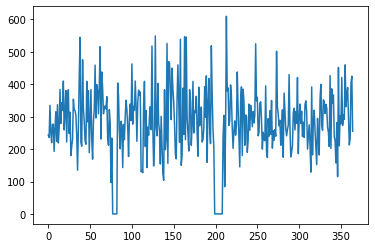

In [352]:
df4.iloc[0].plot()

<AxesSubplot:>

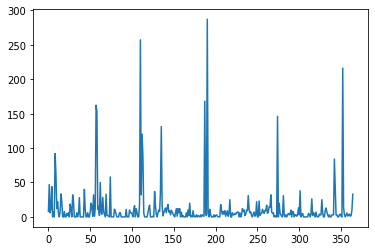

In [353]:
df4.iloc[1].plot()

<AxesSubplot:>

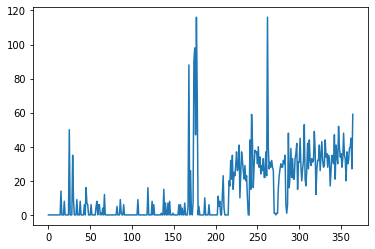

In [354]:
df4.iloc[2].plot()

<AxesSubplot:>

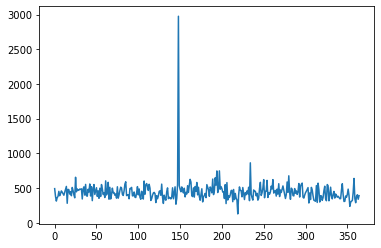

In [355]:
df4.iloc[3].plot()

<AxesSubplot:>

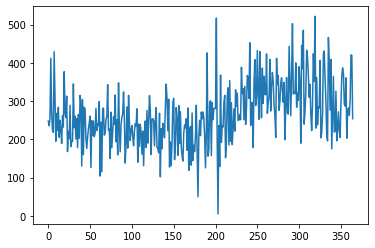

In [356]:
df4.iloc[4].plot()

<AxesSubplot:>

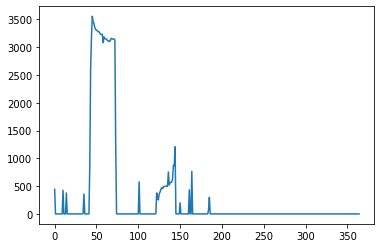

In [357]:
df4.iloc[5].plot()

<AxesSubplot:>

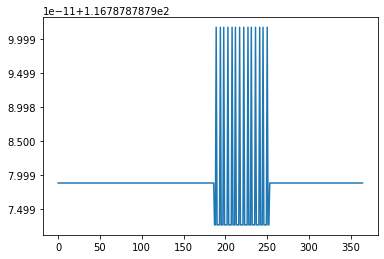

In [358]:
df4.loc[2749].plot()

<AxesSubplot:>

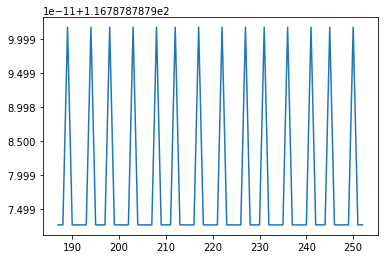

In [359]:
df2.loc[2749].plot()

<AxesSubplot:>

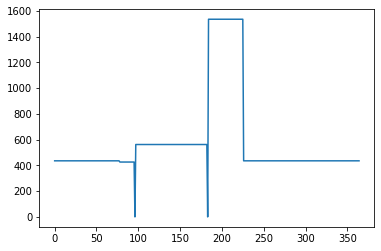

In [361]:
df4.loc[2748].plot()

<AxesSubplot:>

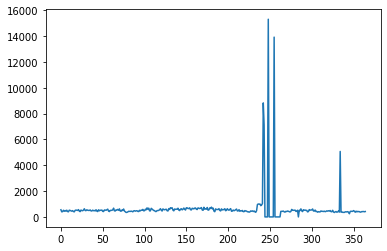

In [362]:
df4.loc[2756].plot()

In [373]:
df4.T

0     1     2      3       4       5      6      7       8      9     \
0    243.0   8.0   0.0  492.0  247.56  442.98   80.0   45.0    4.00  109.0   
1    236.0  47.0   0.0  381.0  235.67    0.00   11.0   36.0    0.00  305.0   
2    335.0   6.0   0.0  313.0  254.33    0.00   69.0  426.0    0.00  205.0   
3    252.0  12.0   0.0  362.0  412.00    0.00  270.0  433.0    7.00  287.0   
4    220.0  44.0   0.0  380.0  269.00    0.00  227.0   63.0    0.00  150.0   
..     ...   ...   ...    ...     ...     ...    ...    ...     ...    ...   
360  213.0   4.0  39.0  289.0  263.06    0.00  204.0  118.0  887.00  149.0   
361  232.0   1.0  40.0  380.0  303.94    0.00  169.0  135.0   12.00  166.0   
362  403.0   2.0  45.0  404.0  421.00    0.00  195.0   77.0  472.00  101.0   
363  425.0  10.0  27.0  339.0  420.00    0.00  152.0   39.0    0.00  122.0   
364  255.0  33.0  59.0  391.0  254.00    0.00  210.0   38.0  332.15   98.0   

     ...  2739        2742        2743        2744        2745        2746  \
0    ...  15.0  205.637255  553.219919  553.219919  614.969444  582.933333   
1    ...  15.0  205.637255  395.367342  395.367342  614.969444  582.933333   
2    ...  15.0  205.637255  410.355298  410.355298  614.969444  582.933333   
3    ...  15.0  205.637255  516.355438  516.355438  614.969444  582.933333   
4    ...  15.0  205.637255  436.190532  436.190532  614.969444  582.933333   
..   ...   ...         ...         ...         ...         ...         ...   
360  ...  15.0  205.637255  414.904301  414.904301  614.969444  582.933333   
361  ...  15.0  205.637255  411.301918  411.301918  614.969444  582.933333   
362  ...  15.0  205.637255  418.423941  418.423941  614.969444  582.933333   
363  ...  15.0  205.637255  400.926486  400.926486  614.969444  582.933333   
364  ...  15.0  205.637255  416.842104  416.842104  614.969444  582.933333   

           2747        2748        2749        2756  
0    553.219919  435.831081  116.787879  553.219919  
1    395.367342  435.831081  116.787879  395.367342  
2    410.355298  435.831081  116.787879  410.355298  
3    516.355438  435.831081  116.787879  516.355438  
4    436.190532  435.831081  116.787879  436.190532  
..          ...         ...         ...         ...  
360  414.904301  435.831081  116.787879  414.904301  
361  411.301918  435.831081  116.787879  411.301918  
362  418.423941  435.831081  116.787879  418.423941  
363  400.926486  435.831081  116.787879  400.926486  
364  416.842104  435.831081  116.787879  416.842104  

[365 rows x 2747 columns]

In [375]:
start_date = datetime.date(2019, 2 , 1)
end_date = datetime.date(2020, 1, 31)
all_dates = get_date_range(start_date, end_date)
len(all_dates)

365

In [381]:
df4.T

0     1     2      3       4       5      6      7       8      9     \
0    243.0   8.0   0.0  492.0  247.56  442.98   80.0   45.0    4.00  109.0   
1    236.0  47.0   0.0  381.0  235.67    0.00   11.0   36.0    0.00  305.0   
2    335.0   6.0   0.0  313.0  254.33    0.00   69.0  426.0    0.00  205.0   
3    252.0  12.0   0.0  362.0  412.00    0.00  270.0  433.0    7.00  287.0   
4    220.0  44.0   0.0  380.0  269.00    0.00  227.0   63.0    0.00  150.0   
..     ...   ...   ...    ...     ...     ...    ...    ...     ...    ...   
360  213.0   4.0  39.0  289.0  263.06    0.00  204.0  118.0  887.00  149.0   
361  232.0   1.0  40.0  380.0  303.94    0.00  169.0  135.0   12.00  166.0   
362  403.0   2.0  45.0  404.0  421.00    0.00  195.0   77.0  472.00  101.0   
363  425.0  10.0  27.0  339.0  420.00    0.00  152.0   39.0    0.00  122.0   
364  255.0  33.0  59.0  391.0  254.00    0.00  210.0   38.0  332.15   98.0   

     ...  2739        2742        2743        2744        2745        2746  \
0    ...  15.0  205.637255  553.219919  553.219919  614.969444  582.933333   
1    ...  15.0  205.637255  395.367342  395.367342  614.969444  582.933333   
2    ...  15.0  205.637255  410.355298  410.355298  614.969444  582.933333   
3    ...  15.0  205.637255  516.355438  516.355438  614.969444  582.933333   
4    ...  15.0  205.637255  436.190532  436.190532  614.969444  582.933333   
..   ...   ...         ...         ...         ...         ...         ...   
360  ...  15.0  205.637255  414.904301  414.904301  614.969444  582.933333   
361  ...  15.0  205.637255  411.301918  411.301918  614.969444  582.933333   
362  ...  15.0  205.637255  418.423941  418.423941  614.969444  582.933333   
363  ...  15.0  205.637255  400.926486  400.926486  614.969444  582.933333   
364  ...  15.0  205.637255  416.842104  416.842104  614.969444  582.933333   

           2747        2748        2749        2756  
0    553.219919  435.831081  116.787879  553.219919  
1    395.367342  435.831081  116.787879  395.367342  
2    410.355298  435.831081  116.787879  410.355298  
3    516.355438  435.831081  116.787879  516.355438  
4    436.190532  435.831081  116.787879  436.190532  
..          ...         ...         ...         ...  
360  414.904301  435.831081  116.787879  414.904301  
361  411.301918  435.831081  116.787879  411.301918  
362  418.423941  435.831081  116.787879  418.423941  
363  400.926486  435.831081  116.787879  400.926486  
364  416.842104  435.831081  116.787879  416.842104  

[365 rows x 2747 columns]

In [387]:
mean_consumption = df4.mean(axis=1)
variance_consumption = df4.var(axis=1)

In [453]:
df5 = pd.DataFrame()

In [454]:
ID = []
DELTA = []
YEAR_DAY = []
DATE = []
MEAN_CONSUMPTION = []
VARIANCE_CONSUMPTION = []
for i in tqdm(df4.T.columns):
    ID += [i for j in range(365)]
    DELTA += list(df4.T[i].values)
    YEAR_DAY += list(df4.columns)
    DATE += all_dates
    MEAN_CONSUMPTION += [mean_consumption[i] for j in range(365)]
    VARIANCE_CONSUMPTION += [variance_consumption[i] for j in range(365)]

100%|█████████████████████████████████████████████████████████████████████████████| 2747/2747 [00:07<00:00, 351.00it/s]


In [455]:
df5['ID'] = ID
df5['DELTA'] = DELTA
df5['YEAR_DAY'] = YEAR_DAY
df5['DATE'] = DATE
df5['MEAN_CONSUMPTION'] = MEAN_CONSUMPTION
df5['VARIANCE_CONSUMPTION'] = VARIANCE_CONSUMPTION
df5.head()

ID  DELTA  YEAR_DAY        DATE  MEAN_CONSUMPTION  VARIANCE_CONSUMPTION
0   0  243.0         0  2019-02-01        282.893151          11453.639651
1   0  236.0         1  2019-02-02        282.893151          11453.639651
2   0  335.0         2  2019-02-03        282.893151          11453.639651
3   0  252.0         3  2019-02-04        282.893151          11453.639651
4   0  220.0         4  2019-02-05        282.893151          11453.639651

In [456]:
from datetime import datetime

def get_weekday(date):
    return date.weekday()

def get_fecha(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d")

def is_weekend(weekday):
    if weekday==5 or weekday==6:
        return 1
    else:
        return 0

In [457]:
df5['DATE'] = df5['DATE'].progress_apply(get_fecha)
df5['WEEKDAY'] = df5['DATE'].progress_apply(get_weekday)
df5['IS_WEEKEND'] = df5['WEEKDAY'].progress_apply(is_weekend)

100%|████████████████████████████████████████████████████████████████████| 1002655/1002655 [00:01<00:00, 892809.12it/s]


In [458]:
days_in_a_week = 7
df5['sin_WEEKDAY'] = np.sin(2*np.pi*df5['WEEKDAY']/days_in_a_week)
df5['cos_WEEKDAY'] = np.cos(2*np.pi*df5['WEEKDAY']/days_in_a_week)
days_in_a_year = 365
df5['sin_year_day'] = np.sin(2*np.pi*df5['YEAR_DAY']/days_in_a_year)
df5['cos_year_day'] = np.cos(2*np.pi*df5['YEAR_DAY']/days_in_a_year)

#### Datos temperatura

In [459]:
import json
temperatura_valencia  = []
with open('../data/Temperatura_Valencia.txt') as json_file:
    temperatura_valencia = json.load(json_file)

In [460]:
fechas = []
precipitaciones = []
Min_Temp = []
Max_Temp = []
Sol = []
Mean_Temp = []
for dato in temperatura_valencia:
    fechas.append(dato['fecha'])
    if dato['prec'] == 'Ip':
        precipitaciones.append(None)
    else:
        precipitaciones.append(dato['prec'])
    Min_Temp.append(dato['tmin'])
    Mean_Temp.append(dato['tmed'])
    Max_Temp.append(dato['tmax'])
    try:
        Sol.append(dato['sol'])
    except:
        Sol.append(None)

In [461]:
temperaturas = pd.DataFrame()
temperaturas['Fechas'] = fechas
temperaturas['PRECIPITATIONS'] = precipitaciones
temperaturas['MIN_TEMP'] = Min_Temp
temperaturas['MEAN_TEMP'] = Mean_Temp
temperaturas['MAX_TEMP'] = Max_Temp
temperaturas['SUN'] = Sol

In [462]:
def coma2float(string):
    return float(string.replace(',','.')) if type(string) == str else string

In [463]:
temperaturas['PRECIPITATIONS'] = temperaturas['PRECIPITATIONS'].map(coma2float)
temperaturas['MIN_TEMP'] = temperaturas['MIN_TEMP'].map(coma2float)
temperaturas['MEAN_TEMP'] = temperaturas['MEAN_TEMP'].map(coma2float)
temperaturas['MAX_TEMP'] = temperaturas['MAX_TEMP'].map(coma2float)
temperaturas['SUN'] = temperaturas['SUN'].map(coma2float)

In [464]:
temperaturas['Fechas'] = temperaturas['Fechas'].progress_apply(get_fecha)

100%|█████████████████████████████████████████████████████████████████████████████| 425/425 [00:00<00:00, 71041.73it/s]


In [465]:
temperaturas.head()

Fechas  PRECIPITATIONS  MIN_TEMP  MEAN_TEMP  MAX_TEMP  SUN
0 2019-01-01             0.0       5.8       11.9      18.0  6.0
1 2019-01-02             0.0       5.2       12.0      18.8  8.7
2 2019-01-03             0.0       4.4       10.5      16.6  7.7
3 2019-01-04             0.0       4.4       10.2      16.1  8.4
4 2019-01-05             0.0       6.1       12.4      18.7  8.7

#### Merge all

In [466]:
df6 = pd.merge(df5, temperaturas, left_on='DATE', right_on = 'Fechas')
df6.drop('Fechas',axis=1,inplace=True)
df6.head()

ID   DELTA  YEAR_DAY       DATE  MEAN_CONSUMPTION  VARIANCE_CONSUMPTION  \
0   0  243.00         0 2019-02-01        282.893151          11453.639651   
1   1    8.00         0 2019-02-01         11.690411            960.421214   
2   2    0.00         0 2019-02-01         14.731507            363.554087   
3   3  492.00         0 2019-02-01        443.627397          25350.257948   
4   4  247.56         0 2019-02-01        265.456329           6416.593867   

   WEEKDAY  IS_WEEKEND  sin_WEEKDAY  cos_WEEKDAY  sin_year_day  cos_year_day  \
0        4           0    -0.433884    -0.900969           0.0           1.0   
1        4           0    -0.433884    -0.900969           0.0           1.0   
2        4           0    -0.433884    -0.900969           0.0           1.0   
3        4           0    -0.433884    -0.900969           0.0           1.0   
4        4           0    -0.433884    -0.900969           0.0           1.0   

   PRECIPITATIONS  MIN_TEMP  MEAN_TEMP  MAX_TEMP  SUN  
0             0.0      16.5       17.6      18.7  7.1  
1             0.0      16.5       17.6      18.7  7.1  
2             0.0      16.5       17.6      18.7  7.1  
3             0.0      16.5       17.6      18.7  7.1  
4             0.0      16.5       17.6      18.7  7.1

#### Add column to say which counters are good (delta for more than 300 days) and which are not

In [467]:
with_missings = (df.T).isna().sum()[(df.T).isna().sum() > 300].index
with_missings 

Int64Index([ 438, 2403, 2423, 2433, 2435, 2441, 2442, 2518, 2521, 2524, 2525,
            2526, 2529, 2530, 2536, 2541, 2543, 2562, 2574, 2578, 2580, 2582,
            2584, 2587, 2588, 2598, 2599, 2602, 2605, 2609, 2612, 2613, 2614,
            2616, 2617, 2623, 2633, 2636, 2637, 2639, 2640, 2649, 2652, 2658,
            2660, 2665, 2668, 2671, 2672, 2673, 2680, 2681, 2686, 2687, 2688,
            2695, 2698, 2706, 2708, 2710, 2713, 2714, 2715, 2716, 2717, 2718,
            2719, 2720, 2721, 2722, 2723, 2724, 2725, 2727, 2728, 2729, 2730,
            2731, 2732, 2733, 2734, 2735, 2736, 2737, 2739, 2742, 2743, 2744,
            2745, 2746, 2747, 2748, 2749, 2756],
           dtype='int64', name='ID')

In [468]:
def is_good(i):
    if i in list(with_missings):
        return -1
    else:
        return 1

In [469]:
df6['IS_GOOD'] = df6['ID'].progress_apply(is_good)
df6 = df6.sort_values(['ID','DATE']).reset_index(drop=True)
df6.head()

100%|████████████████████████████████████████████████████████████████████| 1002655/1002655 [00:09<00:00, 105746.61it/s]


ID  DELTA  YEAR_DAY       DATE  MEAN_CONSUMPTION  VARIANCE_CONSUMPTION  \
0   0  243.0         0 2019-02-01        282.893151          11453.639651   
1   0  236.0         1 2019-02-02        282.893151          11453.639651   
2   0  335.0         2 2019-02-03        282.893151          11453.639651   
3   0  252.0         3 2019-02-04        282.893151          11453.639651   
4   0  220.0         4 2019-02-05        282.893151          11453.639651   

   WEEKDAY  IS_WEEKEND  sin_WEEKDAY  cos_WEEKDAY  sin_year_day  cos_year_day  \
0        4           0    -0.433884    -0.900969      0.000000      1.000000   
1        5           1    -0.974928    -0.222521      0.017213      0.999852   
2        6           1    -0.781831     0.623490      0.034422      0.999407   
3        0           0     0.000000     1.000000      0.051620      0.998667   
4        1           0     0.781831     0.623490      0.068802      0.997630   

   PRECIPITATIONS  MIN_TEMP  MEAN_TEMP  MAX_TEMP  SUN  IS_GOOD  
0             0.0      16.5       17.6      18.7  7.1        1  
1             0.0       9.8       13.4      17.1  6.1        1  
2             0.0       7.7       10.6      13.6  9.3        1  
3             0.0       4.1       10.6      17.2  9.3        1  
4             0.0       7.5       14.6      21.6  9.2        1

In [470]:
df6.to_pickle('../data/df6.pkl')

In [471]:
df6.to_csv('../data/df6.csv', index=False)

In [520]:
df = pd.read_csv('../data/df6.csv')
df = df.drop(['YEAR_DAY','WEEKDAY','IS_GOOD'],axis=1)
df.drop('DATE',axis=1,inplace=True)

In [521]:
df['SUN'] = df['SUN'].fillna(df['SUN'].mean())
df['PRECIPITATIONS'] = df['PRECIPITATIONS'].fillna(df['PRECIPITATIONS'].mean())

### Crear test

In [545]:
import datetime
from tqdm import tqdm

'''
given a start date in datetime format "start_date" and an "end_date" returns a list of strings with the dates from
"start_date" to "end_date".

Example:

start_date = datetime.date(2019, 9 , 30)
end_date = datetime.date(2019, 10, 7)
get_date_range(start_date, end_date)
'''
def get_date_range(start_date, end_date):
    number_of_days = (end_date-start_date).days
    return [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days+1)]

In [546]:
start_date = datetime.date(2020, 2 , 1)
end_date = datetime.date(2020, 2, 14)
fechas_test = get_date_range(start_date, end_date)

In [547]:
ID = []
DATE = []
MEAN_CONSUMPTION = []
VARIANCE_CONSUMPTION = []
YEAR_DAY=[]
for i in df6['ID'].unique():
    ID += [i for j in range(14)]
    DATE += fechas_test
    mc = df6[df6['ID']==i]['MEAN_CONSUMPTION'].values[0]
    vc = df6[df6['ID']==i]['VARIANCE_CONSUMPTION'].values[0]
    MEAN_CONSUMPTION += [mc for j in range(14)]
    VARIANCE_CONSUMPTION += [vc for j in range(14)]
    YEAR_DAY += [j for j in range(14)]
test = pd.DataFrame.from_dict({'ID':ID,
                               'DATE':DATE,
                               'MEAN_CONSUMPTION':MEAN_CONSUMPTION,
                               'VARIANCE_CONSUMPTION':VARIANCE_CONSUMPTION,
                               'YEAR_DAY':YEAR_DAY})

In [557]:
from datetime import datetime

test['DATE'] = test['DATE'].progress_apply(get_fecha)
test['WEEKDAY'] = test['DATE'].progress_apply(get_weekday)
test['IS_WEEKEND'] = test['WEEKDAY'].progress_apply(is_weekend)

100%|████████████████████████████████████████████████████████████████████████| 38458/38458 [00:00<00:00, 964157.68it/s]


In [558]:
days_in_a_week = 7
test['sin_WEEKDAY'] = np.sin(2*np.pi*test['WEEKDAY']/days_in_a_week)
test['cos_WEEKDAY'] = np.cos(2*np.pi*test['WEEKDAY']/days_in_a_week)
days_in_a_year = 365
test['sin_year_day'] = np.sin(2*np.pi*test['YEAR_DAY']/days_in_a_year)
test['cos_year_day'] = np.cos(2*np.pi*test['YEAR_DAY']/days_in_a_year)

In [559]:
test = pd.merge(test, temperaturas, left_on='DATE', right_on = 'Fechas')
test.drop('Fechas',axis=1,inplace=True)
test.head()

ID       DATE  MEAN_CONSUMPTION  VARIANCE_CONSUMPTION  YEAR_DAY  WEEKDAY  \
0   0 2020-02-01        282.893151          11453.639651         0        5   
1   1 2020-02-01         11.690411            960.421214         0        5   
2   2 2020-02-01         14.731507            363.554087         0        5   
3   3 2020-02-01        443.627397          25350.257948         0        5   
4   4 2020-02-01        265.456329           6416.593867         0        5   

   IS_WEEKEND  sin_WEEKDAY  cos_WEEKDAY  sin_year_day  cos_year_day  \
0           1    -0.974928    -0.222521           0.0           1.0   
1           1    -0.974928    -0.222521           0.0           1.0   
2           1    -0.974928    -0.222521           0.0           1.0   
3           1    -0.974928    -0.222521           0.0           1.0   
4           1    -0.974928    -0.222521           0.0           1.0   

   PRECIPITATIONS  MIN_TEMP  MEAN_TEMP  MAX_TEMP  SUN  
0             0.0      13.8       20.4      27.1  7.0  
1             0.0      13.8       20.4      27.1  7.0  
2             0.0      13.8       20.4      27.1  7.0  
3             0.0      13.8       20.4      27.1  7.0  
4             0.0      13.8       20.4      27.1  7.0

In [528]:
test.isna().sum()

ID                      0
DATE                    0
MEAN_CONSUMPTION        0
VARIANCE_CONSUMPTION    0
YEAR_DAY                0
WEEKDAY                 0
IS_WEEKEND              0
sin_WEEKDAY             0
cos_WEEKDAY             0
sin_year_day            0
cos_year_day            0
PRECIPITATIONS          0
MIN_TEMP                0
MEAN_TEMP               0
MAX_TEMP                0
SUN                     0
dtype: int64

In [533]:
test = test.drop(['YEAR_DAY','WEEKDAY'],axis=1)
test.drop('DATE',axis=1,inplace=True)

### Entrenar

In [534]:
X_train = df.drop(['DELTA'], axis=1)
y_train = df['DELTA']
X_test = test

In [535]:
X_train.head()

ID  MEAN_CONSUMPTION  VARIANCE_CONSUMPTION  IS_WEEKEND  sin_WEEKDAY  \
0   0        282.893151          11453.639651           0    -0.433884   
1   0        282.893151          11453.639651           1    -0.974928   
2   0        282.893151          11453.639651           1    -0.781831   
3   0        282.893151          11453.639651           0     0.000000   
4   0        282.893151          11453.639651           0     0.781831   

   cos_WEEKDAY  sin_year_day  cos_year_day  PRECIPITATIONS  MIN_TEMP  \
0    -0.900969      0.000000      1.000000             0.0      16.5   
1    -0.222521      0.017213      0.999852             0.0       9.8   
2     0.623490      0.034422      0.999407             0.0       7.7   
3     1.000000      0.051620      0.998667             0.0       4.1   
4     0.623490      0.068802      0.997630             0.0       7.5   

   MEAN_TEMP  MAX_TEMP  SUN  
0       17.6      18.7  7.1  
1       13.4      17.1  6.1  
2       10.6      13.6  9.3  
3       10.6      17.2  9.3  
4       14.6      21.6  9.2

In [536]:
X_test.head()

ID  MEAN_CONSUMPTION  VARIANCE_CONSUMPTION  IS_WEEKEND  sin_WEEKDAY  \
0   0        282.893151          11453.639651           1    -0.974928   
1   1         11.690411            960.421214           1    -0.974928   
2   2         14.731507            363.554087           1    -0.974928   
3   3        443.627397          25350.257948           1    -0.974928   
4   4        265.456329           6416.593867           1    -0.974928   

   cos_WEEKDAY  sin_year_day  cos_year_day  PRECIPITATIONS  MIN_TEMP  \
0    -0.222521           0.0           1.0             0.0      13.8   
1    -0.222521           0.0           1.0             0.0      13.8   
2    -0.222521           0.0           1.0             0.0      13.8   
3    -0.222521           0.0           1.0             0.0      13.8   
4    -0.222521           0.0           1.0             0.0      13.8   

   MEAN_TEMP  MAX_TEMP  SUN  
0       20.4      27.1  7.0  
1       20.4      27.1  7.0  
2       20.4      27.1  7.0  
3       20.4      27.1  7.0  
4       20.4      27.1  7.0

In [541]:
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge

model1 = xgb.XGBRegressor(
    n_estimators=1000,
    reg_lambda=1,
    gamma=0,
    max_depth=8
)

model2 = GradientBoostingRegressor()
model3 = Ridge()

In [542]:
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)

C:\Users\sergi\Anaconda3\envs\cajamar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\sergi\Anaconda3\envs\cajamar\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.17235e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Ridge()

In [543]:
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

C:\Users\sergi\Anaconda3\envs\cajamar\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [560]:
results_df = pd.DataFrame.from_dict({'ID':test['ID'].values, 
                                     'DATE':test['DATE'].values,
                                     'y_pred1':y_pred1,
                                     'y_pred2':y_pred2,
                                     'y_pred3':y_pred3})

In [561]:
results_df

ID       DATE     y_pred1     y_pred2     y_pred3
0         0 2020-02-01  231.098190  258.204221  158.007085
1         1 2020-02-01   24.360508   44.927825 -113.195655
2         2 2020-02-01   12.773033   44.927825 -110.154559
3         3 2020-02-01  436.613770  373.720959  318.741332
4         4 2020-02-01  226.152359  228.973484  140.570263
...     ...        ...         ...         ...         ...
38453  2746 2020-02-14  556.492004  476.510731  485.864395
38454  2747 2020-02-14  570.841858  546.662687  519.161205
38455  2748 2020-02-14  454.320038  476.510731  492.332256
38456  2749 2020-02-14  138.689224  114.352742   19.718940
38457  2756 2020-02-14  561.492249  546.662687  519.161205

[38458 rows x 5 columns]

In [562]:
results_df['FINAL'] = results_df[['y_pred1','y_pred2']].mean(axis=1)

In [564]:
results_df.drop(['y_pred1','y_pred2','y_pred3'],axis=1,inplace=True)

In [567]:
results_df = results_df.sort_values(['ID','DATE'])

In [568]:
results_df

ID       DATE       FINAL
0         0 2020-02-01  244.651206
2747      0 2020-02-02  258.836013
5494      0 2020-02-03  285.048875
8241      0 2020-02-04  277.551987
10988     0 2020-02-05  294.659810
...     ...        ...         ...
27469  2756 2020-02-10  503.823378
30216  2756 2020-02-11  500.209532
32963  2756 2020-02-12  506.479709
35710  2756 2020-02-13  521.393477
38457  2756 2020-02-14  554.077468

[38458 rows x 3 columns]

In [579]:
ID = []
Dia_1 = []
Dia_2 = []
Dia_3 = []
Dia_4 = []
Dia_5 = []
Dia_6 = []
Dia_7 = []
for i, fecha in enumerate(fechas_test[0:7]):
    aux = results_df[results_df['DATE']==fecha]
    ID = list(aux['ID'].values)
    if i==0:
        Dia_1 += list(aux['FINAL'].values)
    if i==1:
        Dia_2 += list(aux['FINAL'].values)
    if i==2:
        Dia_3 += list(aux['FINAL'].values)
    if i==3:
        Dia_4 += list(aux['FINAL'].values)
    if i==4:
        Dia_5 += list(aux['FINAL'].values)
    if i==5:
        Dia_6 += list(aux['FINAL'].values)
    if i==6:
        Dia_7 += list(aux['FINAL'].values)
print(len(ID),len(Dia_1))
final_df = pd.DataFrame.from_dict({'ID':ID,
                                   'Dia_1':Dia_1,
                                  'Dia_2':Dia_2,
                                  'Dia_3':Dia_3,
                                  'Dia_4':Dia_4,
                                  'Dia_5':Dia_5,
                                  'Dia_6':Dia_6,
                                  'Dia_7':Dia_7,})

2747 2747


In [583]:
ID = []
Dia_8 = []
Dia_9 = []
Dia_10 = []
Dia_11 = []
Dia_12 = []
Dia_13 = []
Dia_14 = []
for i, fecha in enumerate(fechas_test[7:14]):
    aux = results_df[results_df['DATE']==fecha]
    ID = list(aux['ID'].values)
    if i==0:
        Dia_8 += list(aux['FINAL'].values)
    if i==1:
        Dia_9 += list(aux['FINAL'].values)
    if i==2:
        Dia_10 += list(aux['FINAL'].values)
    if i==3:
        Dia_11 += list(aux['FINAL'].values)
    if i==4:
        Dia_12 += list(aux['FINAL'].values)
    if i==5:
        Dia_13 += list(aux['FINAL'].values)
    if i==6:
        Dia_14 += list(aux['FINAL'].values)
print(len(ID),len(Dia_11))
final_df2 = pd.DataFrame.from_dict({'ID':ID,
                                   'Dia_8':Dia_8,
                                  'Dia_9':Dia_9,
                                  'Dia_10':Dia_10,
                                  'Dia_11':Dia_11,
                                  'Dia_12':Dia_12,
                                  'Dia_13':Dia_13,
                                  'Dia_14':Dia_14,})

2747 2747


In [591]:
final_df['Semana_1'] = final_df[['Dia_1','Dia_2','Dia_3','Dia_4','Dia_5','Dia_6','Dia_7']].sum(axis=1)

In [592]:
final_df['Semana_2'] = final_df2[['Dia_8','Dia_9','Dia_10','Dia_11','Dia_12','Dia_13','Dia_14']].sum(axis=1)

In [595]:
final_df

ID       Dia_1       Dia_2       Dia_3       Dia_4       Dia_5  \
0        0  244.651206  258.836013  285.048875  277.551987  294.659810   
1        1   34.644167   33.843484   48.639075   49.429721   37.348305   
2        2   28.850429   31.438800   50.767789   51.558441   39.477004   
3        3  405.167364  390.098806  444.003044  409.373283  405.008404   
4        4  227.562921  237.335230  278.632953  278.043934  271.424049   
...    ...         ...         ...         ...         ...         ...   
2742  2746  536.589668  497.985054  506.785456  536.746759  486.387739   
2743  2747  438.942639  427.251874  478.074431  442.635695  571.382739   
2744  2748  416.858101  431.171044  465.048929  403.434534  441.822584   
2745  2749  133.468148  109.933663  126.899119  135.766642  112.473006   
2746  2756  445.903806  445.540524  475.283995  439.845259  570.313830   

           Dia_6       Dia_7     Semana_1     Semana_2  
0     284.382844  285.154200  1930.284934  1953.973128  
1      36.105948   33.172468   273.183168   273.048200  
2      38.234663   35.301189   275.628315   286.605261  
3     399.092247  413.459764  2866.202913  2945.805634  
4     272.996021  255.082410  1821.077519  1822.865055  
...          ...         ...          ...          ...  
2742  508.853235  503.252063  3576.599976  3570.777664  
2743  481.584838  516.637963  3356.510178  3551.184372  
2744  458.494501  439.224720  3056.054413  3162.506653  
2745  120.917166  107.014736   846.472480   826.294554  
2746  480.515959  514.684181  3372.087555  3535.201507  

[2747 rows x 10 columns]

In [596]:
final_df.to_csv('../data/La Manzana de Newton.txt', sep = '|', header=False, index=False)